In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fer2013/fer2013.csv


In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Conv2D, MaxPool2D, AveragePooling2D, Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from keras.preprocessing import image
import scipy
import os
import cv2


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data = pd.read_csv('/kaggle/input/fer2013/fer2013.csv')

In [4]:
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [5]:
x_data = data['pixels']
y_data = data['emotion']

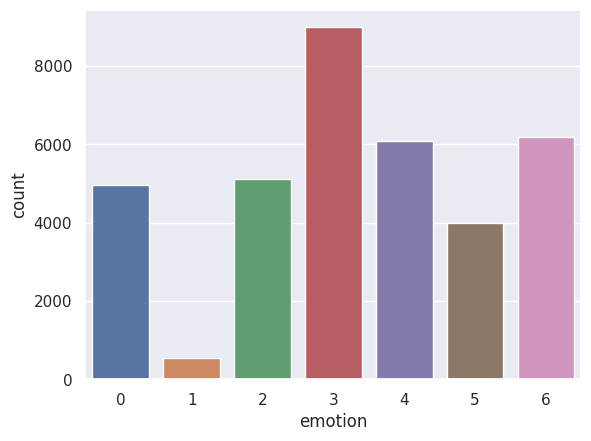

In [6]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="emotion", data=data)

In [7]:
oversampler = RandomOverSampler(sampling_strategy='auto')

x_data, y_data = oversampler.fit_resample(x_data.values.reshape(-1,1), y_data)
print(x_data.shape," ",y_data.shape)

(62923, 1)   (62923,)


In [8]:
y_data.value_counts()

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64

In [9]:
x_data = pd.Series(x_data.flatten())
x_data

0        70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1        151 150 147 155 148 133 111 140 170 174 182 15...
2        231 212 156 164 174 138 161 173 182 200 106 38...
3        24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4        4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
                               ...                        
62918    153 153 154 150 148 146 121 104 98 78 51 58 90...
62919    70 70 70 71 79 89 100 113 108 96 92 111 149 17...
62920    165 167 167 165 164 166 159 160 160 161 158 16...
62921    89 92 95 99 104 107 111 115 122 118 48 53 43 3...
62922    197 202 203 199 202 197 197 192 184 199 198 19...
Length: 62923, dtype: object

In [10]:
x_data = np.array(list(map(str.split, x_data)), np.float32)
x_data/=255
x_data[:10]

array([[0.27450982, 0.3137255 , 0.32156864, ..., 0.41568628, 0.42745098,
        0.32156864],
       [0.5921569 , 0.5882353 , 0.5764706 , ..., 0.75686276, 0.7176471 ,
        0.72156864],
       [0.90588236, 0.83137256, 0.6117647 , ..., 0.34509805, 0.43137255,
        0.59607846],
       ...,
       [0.3019608 , 0.30588236, 0.30980393, ..., 0.49019608, 0.2627451 ,
        0.26666668],
       [0.33333334, 0.32941177, 0.3529412 , ..., 0.22745098, 0.28627452,
        0.32941177],
       [1.        , 0.99607843, 1.        , ..., 0.99607843, 1.        ,
        1.        ]], dtype=float32)

In [11]:
x_data = x_data.reshape(-1, 48, 48, 1)
x_data.shape

(62923, 48, 48, 1)

In [12]:
y_data = np.array(y_data)
y_data = y_data.reshape(y_data.shape[0], 1)
y_data.shape

(62923, 1)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state = 45)

In [14]:
model = Sequential([
    Input((48, 48, 1)),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.6),
    Dense(7, activation = 'softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 46, 46, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 46, 46, 64)        0

In [15]:
# tf.keras.utils.plot_model(model, to_file = "model.png", show_shapes = True, show_dtype = True)

In [16]:
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
y_train = np_utils.to_categorical(y_train, 7)
y_train.shape

(56630, 7)

In [18]:
y_test = np_utils.to_categorical(y_test, 7)
y_test.shape

(6293, 7)

In [19]:
history = model.fit(x_train, y_train, epochs = 30, validation_data=(x_test, y_test))

Epoch 1/30
1770/1770 [==============================] - 26s 9ms/step - loss: 1.7502 - accuracy: 0.3145 - val_loss: 1.4671 - val_accuracy: 0.4427
Epoch 2/30
1770/1770 [==============================] - 16s 9ms/step - loss: 1.4158 - accuracy: 0.4588 - val_loss: 1.1893 - val_accuracy: 0.5606
Epoch 3/30
1770/1770 [==============================] - 17s 9ms/step - loss: 1.2258 - accuracy: 0.5305 - val_loss: 1.1357 - val_accuracy: 0.5581
Epoch 4/30
1770/1770 [==============================] - 16s 9ms/step - loss: 1.1005 - accuracy: 0.5784 - val_loss: 1.0210 - val_accuracy: 0.6018
Epoch 5/30
1770/1770 [==============================] - 16s 9ms/step - loss: 1.0110 - accuracy: 0.6124 - val_loss: 0.9210 - val_accuracy: 0.6529
Epoch 6/30
1770/1770 [==============================] - 16s 9ms/step - loss: 0.9373 - accuracy: 0.6435 - val_loss: 0.9042 - val_accuracy: 0.6603
Epoch 7/30
1770/1770 [==============================] - 17s 9ms/step - loss: 0.8624 - accuracy: 0.6720 - val_loss: 0.8287 - val_ac

In [20]:
print("Accuracy of our model on validation data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

197/197 [==============================] - 1s 4ms/step - loss: 0.8776 - accuracy: 0.8277
Accuracy of our model on validation data :  82.77451395988464 %


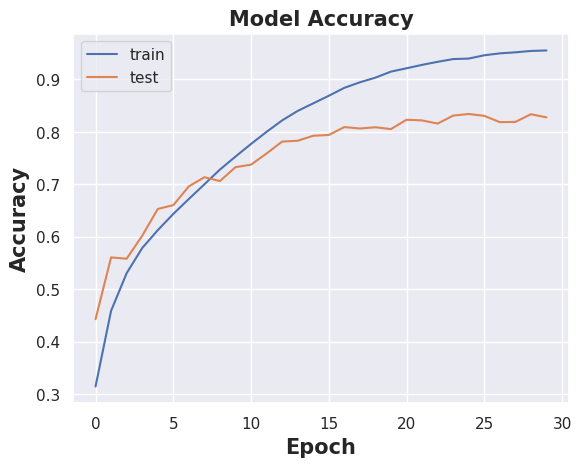

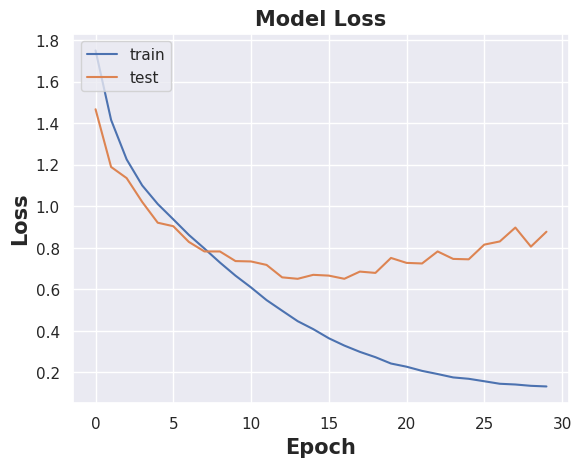

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
plt.title('Model Accuracy', fontsize = 15, fontweight=1000)
plt.ylabel('Accuracy', fontsize = 15, fontweight=700)
plt.xlabel('Epoch', fontsize = 15, fontweight=700)
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
plt.title('Model Loss', fontsize = 15, fontweight=1000)
plt.ylabel('Loss', fontsize = 15, fontweight=700)
plt.xlabel('Epoch', fontsize = 15, fontweight=700)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

197/197 [==============================] - 1s 3ms/step


[6, 5, 5, 6, 1, 0, 3, 4, 1, 6]

In [23]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       935
           1       0.99      1.00      1.00       895
           2       0.76      0.82      0.79       880
           3       0.83      0.75      0.79       906
           4       0.65      0.78      0.71       888
           5       0.94      0.95      0.95       869
           6       0.82      0.68      0.74       920

    accuracy                           0.83      6293
   macro avg       0.83      0.83      0.83      6293
weighted avg       0.83      0.83      0.83      6293



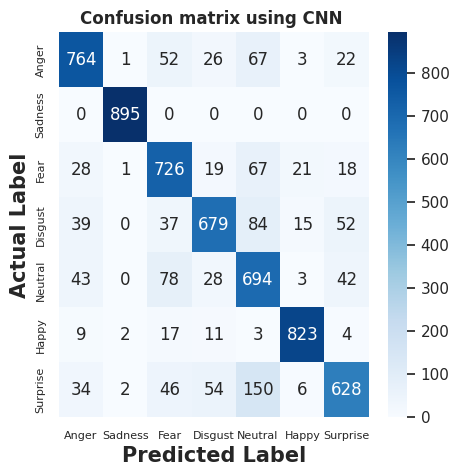

In [25]:
# import seaborn as sn
# cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

# plt.figure(figsize = (5, 4))
# sn.heatmap(cm, annot = True, fmt = 'd',cmap=plt.cm.Blues)
# plt.xlabel('Predicted')
# plt.ylabel('Truth')
import seaborn as sn
cm = tf.math.confusion_matrix(labels = y_actual, predictions = y_result)

plt.figure(figsize = (5,5))
ax = plt.axes()
sn.heatmap(cm,cmap="Blues", annot = True, fmt = 'd')
ax.xaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"], fontsize=8);
ax.yaxis.set_ticklabels([  "Anger", "Sadness", "Fear", "Disgust", "Neutral","Happy","Surprise"],  fontsize=8);

plt.title('Confusion matrix using CNN ', fontsize = 12, fontweight=1000)
plt.xlabel('Predicted Label', fontsize = 15, fontweight=1000)
plt.ylabel('Actual Label', fontsize = 15, fontweight=1000)


plt.savefig("confusion")

In [26]:
fer_json = model.to_json()  
with open("fer.json", "w") as json_file:  
    json_file.write(fer_json)  
model.save("model.h5") 